In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
import wandb
import h5py

import sys
sys.path.append('../../../src/benchmark/')
sys.path.append('../../../src/utils/')
from build_model import resnet50_
from train_functions import train_epochs
from utils import split_train_valid, list_to_dict, viz_dataloader, hdf5_dataset

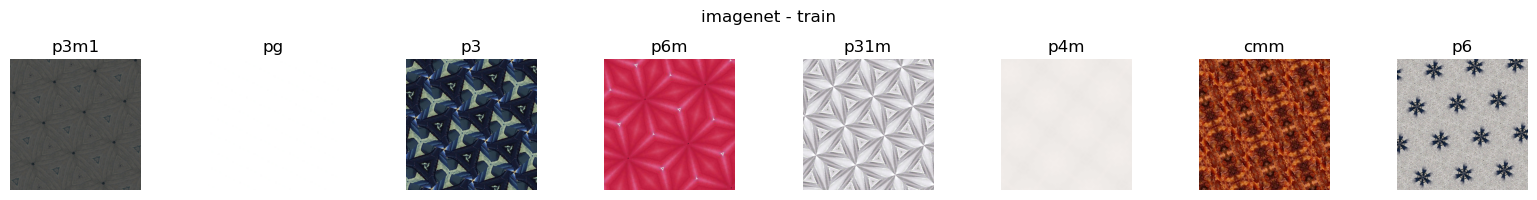

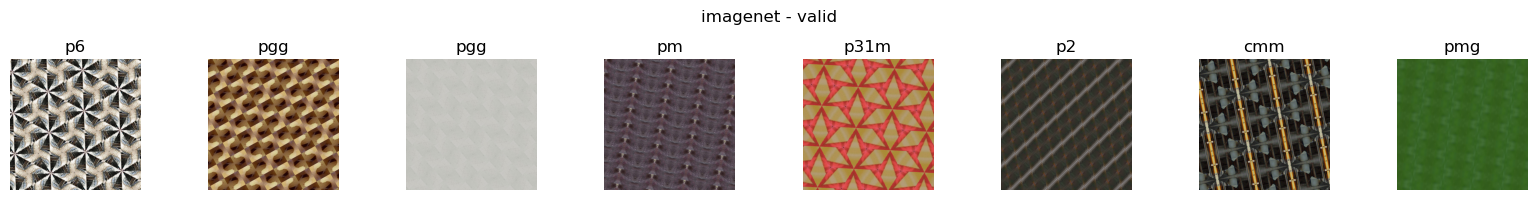

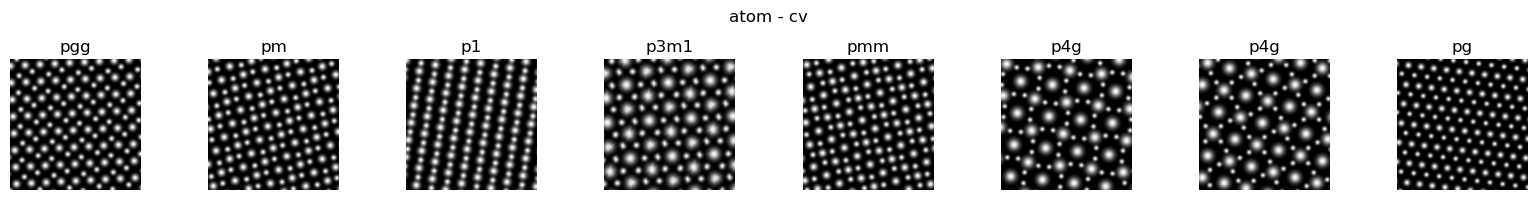

In [2]:
symmetry_classes = ['p1', 'p2', 'pm', 'pg', 'cm', 'pmm', 'pmg', 'pgg', 'cmm', 'p4', 'p4m', 'p4g', 'p3', 'p3m1', 'p31m', 'p6', 'p6m']
label_converter = list_to_dict(symmetry_classes)

# imagenet
imagenet_ds = hdf5_dataset('../../../../imagenet_v5_rot_10m.h5', folder='train', transform=transforms.ToTensor())
train_ds, valid_ds = split_train_valid(imagenet_ds, 0.8)
train_dl = DataLoader(train_ds, batch_size=800, shuffle=True, num_workers=4)
viz_dataloader(train_dl, label_converter=label_converter, title='imagenet - train')
valid_dl = DataLoader(valid_ds, batch_size=800, shuffle=False, num_workers=4)
viz_dataloader(valid_dl, label_converter=label_converter, title='imagenet - valid')

# atom
atom_ds = hdf5_dataset('../../../../atom_v5_rot_200k.h5', folder='test', transform=transforms.ToTensor())
atom_dl = DataLoader(atom_ds, batch_size=800, shuffle=False, num_workers=4)
viz_dataloader(atom_dl, label_converter=label_converter, title='atom - cv')

In [ ]:
# noise
noise_ds = hdf5_dataset('../../../../imagenet_atom_noise_v4_rot_10m_100k_subset.h5', folder='noise', transform=transforms.ToTensor())
noise_dl = DataLoader(noise_ds, batch_size=800, shuffle=False, num_workers=4)
viz_dataloader(noise_dl, label_converter=label_converter, title='noise - cv')

In [4]:
model = resnet50_(in_channels=3, n_classes=17)
outputs = model(torch.randn(2,3,256,256))
print(outputs.shape)
model = torch.nn.DataParallel(model, device_ids=[1,3])
# model

torch.Size([2, 17])


In [5]:
config = {
    'dataset': '10 million datasets',
    'loss_func': 'CrossEntropyLoss', # nn.MSELoss()
    'optimizer': 'Adam',
    'scheduler': 'OneCycleLR',
}

NAME = '05242024-benchmark-resnet50_from_scratch-v5_10m'

# train

In [6]:
wandb.login()
proj_name = 'Understanding-Experimental-Images-by-Identifying-Symmetries-with-Deep-Learning'
wandb.init(project=proj_name, entity='yig319', name=NAME, id=NAME, save_code=True, config=config)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yig319. Use `wandb login --relogin` to force relogin


In [7]:
device = torch.device('cuda:1')
lr = 1e-3
start = 0
epochs = 20

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, epochs=epochs, max_lr=lr, steps_per_epoch=len(train_dl))
history = train_epochs(model, loss_func, optimizer, device, train_dl, valid_dl, cv_dl_list=[atom_dl], cv_name_list=['atom'],
                       epochs=epochs, start=start, scheduler=scheduler, model_dir='../../../saved_models/', tracking=False)

Epoch: 1/20


  0%|          | 0/10711 [00:00<?, ?it/s]

100%|██████████| 10711/10711 [3:12:04<00:00,  1.08s/it] 


Training: Loss: 0.9434, Accuracy: 68.3690%.


100%|██████████| 2678/2678 [32:34<00:00,  1.37it/s]


Validation: Loss: 0.4529, Accuracy: 84.5285%.


100%|██████████| 255/255 [03:50<00:00,  1.11it/s]


atom: Loss: 1.7777, Accuracy: 58.3314%.
Epoch: 2/20


100%|██████████| 10711/10711 [3:13:42<00:00,  1.09s/it] 


Training: Loss: 0.1690, Accuracy: 94.7669%.


100%|██████████| 2678/2678 [35:39<00:00,  1.25it/s]


Validation: Loss: 0.1153, Accuracy: 96.4087%.


100%|██████████| 255/255 [03:16<00:00,  1.30it/s]


atom: Loss: 1.2632, Accuracy: 69.7583%.
Epoch: 3/20


100%|██████████| 10711/10711 [3:12:42<00:00,  1.08s/it] 


Training: Loss: 0.0998, Accuracy: 97.0801%.


100%|██████████| 2678/2678 [37:21<00:00,  1.19it/s]


Validation: Loss: 0.0797, Accuracy: 97.5040%.


100%|██████████| 255/255 [03:49<00:00,  1.11it/s]


atom: Loss: 1.2005, Accuracy: 75.5740%.
Epoch: 4/20


100%|██████████| 10711/10711 [3:13:29<00:00,  1.08s/it] 


Training: Loss: 0.0780, Accuracy: 97.6877%.


100%|██████████| 2678/2678 [37:01<00:00,  1.21it/s]


Validation: Loss: 0.0736, Accuracy: 97.6850%.


100%|██████████| 255/255 [03:09<00:00,  1.35it/s]


atom: Loss: 1.2357, Accuracy: 75.6382%.
Epoch: 5/20


100%|██████████| 10711/10711 [3:16:19<00:00,  1.10s/it] 


Training: Loss: 0.0673, Accuracy: 97.9854%.


100%|██████████| 2678/2678 [37:45<00:00,  1.18it/s]


Validation: Loss: 0.0822, Accuracy: 97.3952%.


100%|██████████| 255/255 [03:24<00:00,  1.25it/s]


atom: Loss: 0.8987, Accuracy: 79.1324%.
Epoch: 6/20


100%|██████████| 10711/10711 [3:17:06<00:00,  1.10s/it] 


Training: Loss: 0.0601, Accuracy: 98.1804%.


100%|██████████| 2678/2678 [42:27<00:00,  1.05it/s] 


Validation: Loss: 0.0569, Accuracy: 98.1801%.


100%|██████████| 255/255 [03:44<00:00,  1.14it/s]


atom: Loss: 1.1386, Accuracy: 76.6250%.
Epoch: 7/20


100%|██████████| 10711/10711 [3:15:08<00:00,  1.09s/it] 


Training: Loss: 0.0550, Accuracy: 98.3161%.


100%|██████████| 2678/2678 [40:04<00:00,  1.11it/s] 


Validation: Loss: 0.0535, Accuracy: 98.2662%.


100%|██████████| 255/255 [03:33<00:00,  1.20it/s]


atom: Loss: 0.7916, Accuracy: 82.4779%.
Epoch: 8/20


100%|██████████| 10711/10711 [3:24:43<00:00,  1.15s/it] 


Training: Loss: 0.0519, Accuracy: 98.3975%.


100%|██████████| 2678/2678 [41:12<00:00,  1.08it/s] 


Validation: Loss: 0.0486, Accuracy: 98.4344%.


100%|██████████| 255/255 [02:53<00:00,  1.47it/s]


atom: Loss: 1.1566, Accuracy: 80.0471%.
Epoch: 9/20


100%|██████████| 10711/10711 [3:11:49<00:00,  1.07s/it] 


Training: Loss: 0.0496, Accuracy: 98.4581%.


100%|██████████| 2678/2678 [35:42<00:00,  1.25it/s]


Validation: Loss: 0.0482, Accuracy: 98.4366%.


100%|██████████| 255/255 [03:15<00:00,  1.30it/s]


atom: Loss: 1.0991, Accuracy: 79.9451%.
Epoch: 10/20


100%|██████████| 10711/10711 [3:13:00<00:00,  1.08s/it] 


Training: Loss: 0.0477, Accuracy: 98.5074%.


100%|██████████| 2678/2678 [38:20<00:00,  1.16it/s]


Validation: Loss: 0.0469, Accuracy: 98.4911%.


100%|██████████| 255/255 [03:59<00:00,  1.07it/s]


atom: Loss: 1.1567, Accuracy: 80.0113%.
Epoch: 11/20


100%|██████████| 10711/10711 [3:14:35<00:00,  1.09s/it] 


Training: Loss: 0.0462, Accuracy: 98.5482%.


100%|██████████| 2678/2678 [47:38<00:00,  1.07s/it] 


Validation: Loss: 0.0465, Accuracy: 98.5034%.


100%|██████████| 255/255 [04:44<00:00,  1.11s/it]


atom: Loss: 1.1725, Accuracy: 81.7309%.
Epoch: 12/20


100%|██████████| 10711/10711 [3:34:01<00:00,  1.20s/it] 


Training: Loss: 0.0447, Accuracy: 98.5891%.


100%|██████████| 2678/2678 [48:44<00:00,  1.09s/it] 


Validation: Loss: 0.0458, Accuracy: 98.5352%.


100%|██████████| 255/255 [04:43<00:00,  1.11s/it]


atom: Loss: 1.3983, Accuracy: 80.1814%.
Epoch: 13/20


100%|██████████| 10711/10711 [3:29:21<00:00,  1.17s/it] 


Training: Loss: 0.0435, Accuracy: 98.6210%.


100%|██████████| 2678/2678 [40:15<00:00,  1.11it/s]


Validation: Loss: 0.0452, Accuracy: 98.5545%.


100%|██████████| 255/255 [03:47<00:00,  1.12it/s]


atom: Loss: 1.4201, Accuracy: 79.4525%.
Epoch: 14/20


100%|██████████| 10711/10711 [3:27:04<00:00,  1.16s/it] 


Training: Loss: 0.0424, Accuracy: 98.6499%.


100%|██████████| 2678/2678 [39:17<00:00,  1.14it/s]


Validation: Loss: 0.0451, Accuracy: 98.5726%.


100%|██████████| 255/255 [03:43<00:00,  1.14it/s]


atom: Loss: 1.3551, Accuracy: 81.7245%.
Epoch: 15/20


100%|██████████| 10711/10711 [3:24:27<00:00,  1.15s/it] 


Training: Loss: 0.0413, Accuracy: 98.6742%.


100%|██████████| 2678/2678 [40:44<00:00,  1.10it/s] 


Validation: Loss: 0.0448, Accuracy: 98.5906%.


100%|██████████| 255/255 [04:05<00:00,  1.04it/s]


atom: Loss: 1.2856, Accuracy: 84.6868%.
Epoch: 16/20


100%|██████████| 10711/10711 [3:17:13<00:00,  1.10s/it] 


Training: Loss: 0.0402, Accuracy: 98.6952%.


100%|██████████| 2678/2678 [42:54<00:00,  1.04it/s]


Validation: Loss: 0.0453, Accuracy: 98.5951%.


100%|██████████| 255/255 [03:27<00:00,  1.23it/s]


atom: Loss: 1.4937, Accuracy: 82.4672%.
Epoch: 17/20


100%|██████████| 10711/10711 [3:19:24<00:00,  1.12s/it] 


Training: Loss: 0.0387, Accuracy: 98.7204%.


100%|██████████| 2678/2678 [39:34<00:00,  1.13it/s] 


Validation: Loss: 0.0462, Accuracy: 98.5963%.


100%|██████████| 255/255 [03:32<00:00,  1.20it/s]


atom: Loss: 1.5865, Accuracy: 83.1235%.
Epoch: 18/20


100%|██████████| 10711/10711 [3:17:40<00:00,  1.11s/it] 


Training: Loss: 0.0372, Accuracy: 98.7420%.


100%|██████████| 2678/2678 [40:13<00:00,  1.11it/s] 


Validation: Loss: 0.0467, Accuracy: 98.6070%.


100%|██████████| 255/255 [03:41<00:00,  1.15it/s]


atom: Loss: 1.5279, Accuracy: 83.9515%.
Epoch: 19/20


100%|██████████| 10711/10711 [3:26:59<00:00,  1.16s/it] 


Training: Loss: 0.0362, Accuracy: 98.7564%.


100%|██████████| 2678/2678 [37:19<00:00,  1.20it/s]


Validation: Loss: 0.0477, Accuracy: 98.5979%.


100%|██████████| 255/255 [03:15<00:00,  1.30it/s]


atom: Loss: 1.6757, Accuracy: 83.7833%.
Epoch: 20/20


100%|██████████| 10711/10711 [3:36:39<00:00,  1.21s/it] 


Training: Loss: 0.0357, Accuracy: 98.7655%.


100%|██████████| 2678/2678 [52:28<00:00,  1.18s/it] 


Validation: Loss: 0.0474, Accuracy: 98.6072%.


100%|██████████| 255/255 [04:05<00:00,  1.04it/s]


atom: Loss: 1.5499, Accuracy: 84.0907%.


In [8]:
device = torch.device('cuda:1')
lr = 1e-3
start = 20
epochs = 20

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, epochs=epochs, max_lr=lr, steps_per_epoch=len(train_dl))
history = train_epochs(model, loss_func, optimizer, device, train_dl, valid_dl, cv_dl_list=[atom_dl], cv_name_list=['atom'],
                       epochs=epochs, start=start, scheduler=scheduler, model_dir='../../../saved_models/', tracking=False)

Epoch: 21/40


100%|██████████| 10711/10711 [3:25:02<00:00,  1.15s/it] 


Training: Loss: 0.0358, Accuracy: 98.7619%.


100%|██████████| 2678/2678 [38:50<00:00,  1.15it/s] 


Validation: Loss: 0.0487, Accuracy: 98.6004%.


100%|██████████| 255/255 [03:14<00:00,  1.31it/s]


atom: Loss: 1.7059, Accuracy: 83.6848%.
Epoch: 22/40


100%|██████████| 10711/10711 [3:23:59<00:00,  1.14s/it] 


Training: Loss: 0.0362, Accuracy: 98.7473%.


100%|██████████| 2678/2678 [36:23<00:00,  1.23it/s]


Validation: Loss: 0.0490, Accuracy: 98.5749%.


100%|██████████| 255/255 [03:51<00:00,  1.10it/s]


atom: Loss: 1.7227, Accuracy: 82.4377%.
Epoch: 23/40


100%|██████████| 10711/10711 [3:17:00<00:00,  1.10s/it] 


Training: Loss: 0.0375, Accuracy: 98.7100%.


100%|██████████| 2678/2678 [42:35<00:00,  1.05it/s] 


Validation: Loss: 0.0487, Accuracy: 98.5556%.


100%|██████████| 255/255 [03:57<00:00,  1.07it/s]


atom: Loss: 1.8684, Accuracy: 78.6196%.
Epoch: 24/40


100%|██████████| 10711/10711 [3:18:58<00:00,  1.11s/it] 


Training: Loss: 0.0396, Accuracy: 98.6625%.


100%|██████████| 2678/2678 [43:42<00:00,  1.02it/s] 


Validation: Loss: 0.0486, Accuracy: 98.5232%.


100%|██████████| 255/255 [04:11<00:00,  1.01it/s]


atom: Loss: 1.6089, Accuracy: 79.1672%.
Epoch: 25/40


100%|██████████| 10711/10711 [3:18:22<00:00,  1.11s/it] 


Training: Loss: 0.0413, Accuracy: 98.6199%.


100%|██████████| 2678/2678 [42:51<00:00,  1.04it/s]


Validation: Loss: 0.0500, Accuracy: 98.4745%.


100%|██████████| 255/255 [04:05<00:00,  1.04it/s]


atom: Loss: 1.5230, Accuracy: 78.4990%.
Epoch: 26/40


100%|██████████| 10711/10711 [3:22:48<00:00,  1.14s/it] 


Training: Loss: 0.0420, Accuracy: 98.6044%.


100%|██████████| 2678/2678 [40:02<00:00,  1.11it/s] 


Validation: Loss: 0.0497, Accuracy: 98.5035%.


100%|██████████| 255/255 [03:11<00:00,  1.33it/s]


atom: Loss: 1.6344, Accuracy: 76.5877%.
Epoch: 27/40


100%|██████████| 10711/10711 [3:29:45<00:00,  1.18s/it] 


Training: Loss: 0.0415, Accuracy: 98.6105%.


100%|██████████| 2678/2678 [36:22<00:00,  1.23it/s]


Validation: Loss: 0.0488, Accuracy: 98.5167%.


100%|██████████| 255/255 [03:41<00:00,  1.15it/s]


atom: Loss: 1.5043, Accuracy: 79.0015%.
Epoch: 28/40


100%|██████████| 10711/10711 [3:30:52<00:00,  1.18s/it] 


Training: Loss: 0.0404, Accuracy: 98.6250%.


100%|██████████| 2678/2678 [42:15<00:00,  1.06it/s] 


Validation: Loss: 0.0494, Accuracy: 98.5107%.


100%|██████████| 255/255 [04:37<00:00,  1.09s/it]


atom: Loss: 1.6326, Accuracy: 78.2637%.
Epoch: 29/40


100%|██████████| 10711/10711 [3:21:54<00:00,  1.13s/it] 


Training: Loss: 0.0393, Accuracy: 98.6482%.


100%|██████████| 2678/2678 [38:16<00:00,  1.17it/s]


Validation: Loss: 0.0502, Accuracy: 98.5199%.


100%|██████████| 255/255 [03:15<00:00,  1.30it/s]


atom: Loss: 1.4679, Accuracy: 79.1373%.
Epoch: 30/40


100%|██████████| 10711/10711 [3:19:41<00:00,  1.12s/it] 


Training: Loss: 0.0381, Accuracy: 98.6740%.


100%|██████████| 2678/2678 [39:47<00:00,  1.12it/s] 


Validation: Loss: 0.0506, Accuracy: 98.5247%.


100%|██████████| 255/255 [03:59<00:00,  1.06it/s]


atom: Loss: 1.5585, Accuracy: 81.3206%.
Epoch: 31/40


100%|██████████| 10711/10711 [3:27:29<00:00,  1.16s/it] 


Training: Loss: 0.0370, Accuracy: 98.6991%.


100%|██████████| 2678/2678 [40:20<00:00,  1.11it/s]


Validation: Loss: 0.0505, Accuracy: 98.5458%.


100%|██████████| 255/255 [03:25<00:00,  1.24it/s]


atom: Loss: 1.5500, Accuracy: 80.4745%.
Epoch: 32/40


100%|██████████| 10711/10711 [3:46:20<00:00,  1.27s/it] 


Training: Loss: 0.0361, Accuracy: 98.7206%.


100%|██████████| 2678/2678 [47:59<00:00,  1.08s/it] 


Validation: Loss: 0.0520, Accuracy: 98.5414%.


100%|██████████| 255/255 [04:33<00:00,  1.07s/it]


atom: Loss: 2.0407, Accuracy: 76.8299%.
Epoch: 33/40


100%|██████████| 10711/10711 [3:25:22<00:00,  1.15s/it] 


Training: Loss: 0.0353, Accuracy: 98.7471%.


100%|██████████| 2678/2678 [43:57<00:00,  1.02it/s] 


Validation: Loss: 0.0517, Accuracy: 98.5631%.


100%|██████████| 255/255 [04:18<00:00,  1.01s/it]


atom: Loss: 1.6083, Accuracy: 81.8314%.
Epoch: 34/40


100%|██████████| 10711/10711 [3:39:22<00:00,  1.23s/it] 


Training: Loss: 0.0346, Accuracy: 98.7642%.


100%|██████████| 2678/2678 [46:14<00:00,  1.04s/it] 


Validation: Loss: 0.0517, Accuracy: 98.5592%.


100%|██████████| 255/255 [04:36<00:00,  1.09s/it]


atom: Loss: 2.0650, Accuracy: 79.1162%.
Epoch: 35/40


100%|██████████| 10711/10711 [3:31:56<00:00,  1.19s/it] 


Training: Loss: 0.0340, Accuracy: 98.7810%.


100%|██████████| 2678/2678 [50:25<00:00,  1.13s/it] 


Validation: Loss: 0.0518, Accuracy: 98.5776%.


100%|██████████| 255/255 [04:31<00:00,  1.07s/it]


atom: Loss: 1.8534, Accuracy: 81.0093%.
Epoch: 36/40


100%|██████████| 10711/10711 [3:28:25<00:00,  1.17s/it] 


Training: Loss: 0.0335, Accuracy: 98.7960%.


100%|██████████| 2678/2678 [51:06<00:00,  1.14s/it] 


Validation: Loss: 0.0528, Accuracy: 98.5842%.


100%|██████████| 255/255 [04:50<00:00,  1.14s/it]


atom: Loss: 2.0253, Accuracy: 80.8485%.
Epoch: 37/40


100%|██████████| 10711/10711 [3:43:11<00:00,  1.25s/it] 


Training: Loss: 0.0332, Accuracy: 98.8064%.


100%|██████████| 2678/2678 [52:07<00:00,  1.17s/it] 


Validation: Loss: 0.0530, Accuracy: 98.5937%.


100%|██████████| 255/255 [04:43<00:00,  1.11s/it]


atom: Loss: 2.1159, Accuracy: 81.2025%.
Epoch: 38/40


100%|██████████| 10711/10711 [3:25:46<00:00,  1.15s/it] 


Training: Loss: 0.0329, Accuracy: 98.8147%.


100%|██████████| 2678/2678 [39:33<00:00,  1.13it/s]


Validation: Loss: 0.0534, Accuracy: 98.5953%.


100%|██████████| 255/255 [03:51<00:00,  1.10it/s]


atom: Loss: 1.9830, Accuracy: 81.6515%.
Epoch: 39/40


100%|██████████| 10711/10711 [3:18:54<00:00,  1.11s/it] 


Training: Loss: 0.0328, Accuracy: 98.8203%.


100%|██████████| 2678/2678 [41:41<00:00,  1.07it/s] 


Validation: Loss: 0.0536, Accuracy: 98.5947%.


100%|██████████| 255/255 [04:33<00:00,  1.07s/it]


atom: Loss: 2.0771, Accuracy: 81.7490%.
Epoch: 40/40


100%|██████████| 10711/10711 [3:17:58<00:00,  1.11s/it] 


Training: Loss: 0.0327, Accuracy: 98.8224%.


100%|██████████| 2678/2678 [35:47<00:00,  1.25it/s]


Validation: Loss: 0.0535, Accuracy: 98.5995%.


100%|██████████| 255/255 [03:19<00:00,  1.28it/s]


atom: Loss: 2.0297, Accuracy: 81.5917%.
